In [1]:
# model download 

import torch
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers import GPTNeoForCausalLM, GPT2Tokenizer 
from transformers import AutoTokenizer, AutoModelForCausalLM

# Download the models from huggingface and save them in the cached_models folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model_name in ["gpt2","distilgpt2","EleutherAI/gpt-neo-125M","Qwen/Qwen3-1.7B"]:
    print(model_name)
    if model_name in ["gpt2", "distilgpt2"]:
        model = AutoModelWithLMHead.from_pretrained(model_name).to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")   # Initialize tokenizer
        # number of heads per layer, and number of layers
        num_heads, num_layers = model.config.n_head, model.config.n_layer
        head_dim, max_length = int(model.config.n_embd/num_heads), model.config.n_positions

    elif model_name in ["EleutherAI/gpt-neo-125M"]:
        model = GPTNeoForCausalLM.from_pretrained(model_name).to(device)
        tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side="left")
        num_heads, num_layers = model.config.num_heads, model.config.num_layers
        head_dim, max_length = int(model.config.hidden_size/num_heads), model.config.max_position_embeddings

    elif model_name in ["Qwen/Qwen3-1.7B"]:
        model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-1.7B").to(device)
        tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B", padding_side='left')
        num_heads, num_layers = model.config.num_attention_heads, model.config.num_hidden_layers
        head_dim, max_length = int(model.config.hidden_size/num_heads), model.config.max_position_embeddings

    model.save_pretrained("./saved_models/cached_models/" + model_name)
    tokenizer.save_pretrained("./saved_models/cached_tokenizers/" + model_name)
    print("./saved_models/cached_models/" + model_name)

/Users/shiyijiang/anaconda3/envs/learning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpt2


/Users/shiyijiang/anaconda3/envs/learning/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:2263: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


./saved_models/cached_models/gpt2
distilgpt2
./saved_models/cached_models/distilgpt2
EleutherAI/gpt-neo-125M
./saved_models/cached_models/EleutherAI/gpt-neo-125M
Qwen/Qwen3-1.7B


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


./saved_models/cached_models/Qwen/Qwen3-1.7B


In [3]:
# create model_config.json 

import json 
import torch
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers import GPTNeoForCausalLM, GPT2Tokenizer 
from transformers import AutoTokenizer, AutoModelForCausalLM

model_names = ["gpt2","distilgpt2","EleutherAI/gpt-neo-125M","Qwen/Qwen3-1.7B"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_config = {}

for model_name in model_names:

    models_config[model_name] = {}

    if model_name in ["gpt2", "distilgpt2"]:
        model = AutoModelWithLMHead.from_pretrained("./saved_models/cached_models/" + model_name).to(device)
        tokenizer = AutoTokenizer.from_pretrained("./saved_models/cached_tokenizers/" + model_name, padding_side="left")    
        num_heads, num_layers = model.config.n_head, model.config.n_layer
        head_dim, max_length = int(model.config.n_embd/num_heads), model.config.n_positions

    elif model_name in ["EleutherAI/gpt-neo-125M"]:
        model = GPTNeoForCausalLM.from_pretrained("./saved_models/cached_models/" + model_name).to(device)
        tokenizer = GPT2Tokenizer.from_pretrained("./saved_models/cached_tokenizers/" + model_name, padding_side="left")
        num_heads, num_layers = model.config.num_heads, model.config.num_layers
        head_dim, max_length = int(model.config.hidden_size/num_heads), model.config.max_position_embeddings

    elif model_name in ["Qwen/Qwen3-1.7B"]:
        model = AutoModelForCausalLM.from_pretrained("./saved_models/cached_models/" + model_name).to(device)
        tokenizer = AutoTokenizer.from_pretrained("./saved_models/cached_tokenizers/" + model_name, padding_side="left")
        num_heads, num_layers = model.config.num_attention_heads, model.config.num_hidden_layers
        head_dim, max_length = int(model.config.hidden_size/num_heads), model.config.max_position_embeddings

    models_config[model_name]["num_heads"] = num_heads
    models_config[model_name]["num_layers"] = num_layers
    models_config[model_name]["head_dim"] = head_dim
    models_config[model_name]["max_length"] = max_length

json.dump(models_config, open("./models_config.json", "w"))

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 85.16it/s]


# create scripts 

In [8]:
from pathlib import Path

id = 0
folder_name = "experiment_1"
heads_per_sh = 10
for group in ["gender_and_sex"]:
  for model in ["EleutherAI/gpt-neo-125M"]:

      if model == "EleutherAI/gpt-neo-125M":
        num_all_heads = 144 

      for prompting in ["holistic"]:
        for head_knockout in range(0,num_all_heads,heads_per_sh):
          for seed in range(1,4):
            my_file = open("./scripts/sample.sh")
            string_list = my_file.readlines()

            my_file.close()
            string_list[1] = "#SBATCH --account=def-bengioy_cpu" + "\n"
            string_list[2] = "#SBATCH --cpus-per-task=1" + "\n"
            string_list[3] =  "\n"
            string_list[4] = "#SBATCH --mem=25G" + "\n"
            string_list[8] = "python main.py "

            if model == "EleutherAI/gpt-neo-125M":
              model_name = "N1"
              string_list[4] = "#SBATCH --mem=50G" + "\n"

            elif model == "EleutherAI/gpt-j-6B":
              model_name = "NJ"
              string_list[1] = "#SBATCH --account=def-bengioy_gpu" + "\n"
              string_list[3] = "#SBATCH --gres=gpu:1" + "\n"
              string_list[4] = "#SBATCH --mem=100G" + "\n"
              string_list[8] += " --batch_size 64 "

            elif model == "meta-llama/Llama-2-7b-chat-hf":
              model_name = "L7"
              string_list[1] = "#SBATCH --account=def-bengioy_gpu" + "\n"
              string_list[3] = "#SBATCH --gres=gpu:1" + "\n"
              string_list[4] = "#SBATCH --mem=100G" + "\n"
              string_list[8] += " --batch_size 64 "

            elif model == "EleutherAI/gpt-neo-1.3B":
              model_name = "N2"
              string_list[1] = "#SBATCH --account=def-bengioy_gpu" + "\n"
              string_list[3] = "#SBATCH --gres=gpu:1" + "\n"
              string_list[4] = "#SBATCH --mem=50G" + "\n"
              string_list[8] += " --batch_size 128 "

            elif model == "distilgpt2":
              model_name = "G2D"
            elif model == "gpt2":
              model_name = "G2"
            elif model == "distilroberta-base":
              model_name = "RD"
            elif model == "distilbert-base-cased":
              model_name = "BD"

            string_list[5] = "#SBATCH --time=11:57:00" + "\n"

            if group == "gender_and_sex":
              group_name = "g"
            elif group == "race_ethnicity":
              group_name = "r"
            elif group == "religion":
              group_name = "l"
            elif group == "sexual_orientation":
              group_name = "s"
            elif group == "nationality":
              group_name = "n"

            string_list[8] += " --model " + model

            prompting_abbrev="h"
            string_list[8] += " --targeted_holistic_bias " + group
            string_list[8] += " --prompting " + str(prompting)
            string_list[7] = "sleep " + str(1*id) + "\n"
            file_name = "./scripts/" + folder_name  + "/" + str(prompting_abbrev) + str(seed) + "_" + str(model_name) + "_h" + str(head_knockout) + "_"  + str(group_name)
            string_list[8] = string_list[8] + " --seed " + str(seed)
            temp = string_list[8]
            string_list[8] = temp + " --head_knockout " + str(head_knockout) + "\n"
            for h in range(1,heads_per_sh):
              string_list[8] += temp + " --head_knockout " + str(head_knockout + h) + "\n"
            Path("./scripts/" + folder_name).mkdir(parents=True, exist_ok=True)
            my_file = open(file_name + ".sh", "w")
            new_file_contents = "".join(string_list)
            my_file.write(new_file_contents)
            my_file.close()
          id+=1

In [4]:
import os

# !python maskattentionmap.py --seed 1 --model EleutherAI/gpt-neo-125M --splits valid --targeted_bias gender_and_sex

for headid in range(6, 15): 
    !python maskattentionmap.py --seed 1 --model EleutherAI/gpt-neo-125M --banheads {headid} {headid+1} --splits valid --targeted_bias gender_and_sex

# !python maskattentionmap.py --seed 1 --model EleutherAI/gpt-neo-125M --splits valid --targeted_bias gender_and_sex
# !python maskattentionmap.py --seed 1 --model EleutherAI/gpt-neo-125M --banheads 0 --splits valid --targeted_bias gender_and_sex

Namespace(seed=1, model='EleutherAI/gpt-neo-125M', banheads=[6, 7], splits=['valid'], targeted_bias='gender_and_sex', stride=512, batch_size=128, max_continuation_length=40, max_prompt_length=22)
Currently used model: EleutherAI/gpt-neo-125M
max_length: 2048
num of layers: 12
num of heads: 12
head dim: 64
----------------------------------------------------------------------------------------------------
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=76

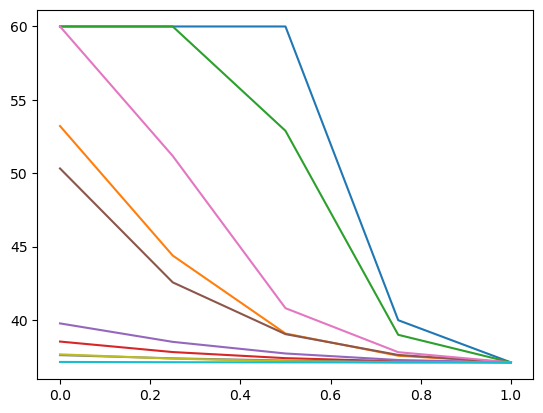

In [ ]:
# 6: 31942914.0 462.683 76.363 39.981 37.105
# 7: 53.215 44.386 39.073 37.559 37.105
# 8: 132045360 3337.913 52.889 38.985 37.105
# 9: 38.525 37.809 37.394 37.178 37.105
# 10: 39.762 38.504 37.712 37.267 37.105

# 130063416 49140572 83513160 42.076

# TODO: two documents (paper, code) 

import json 

import matplotlib.pyplot as plt 

head2ppl = {}

for head_id in range(6, 16):
    ppls = []
    for dir_name in ["./output/1-on-off/", "./output/1-0.25off/", "./output/1-0.5off/", "./output/1-0.75off/"]:
        file_name = dir_name + "EleutherAI_gpt-neo-125M_" + str(head_id) + "/ppl.json"
        ppl = json.load(open(file_name, "r"))["valid"]
        if ppl > 60:
            ppls.append(60.0)
        else:
            ppls.append(ppl)
    ppls.append(37.105)
    plt.plot([0.0, 0.25, 0.5, 0.75, 1.0], ppls)

plt.show()


# PPL 分段线形  

In [2]:
# head contribution 
import pandas as pd
import os
import torch
import json
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_all_seeds = pd.DataFrame() 

# this files has the information about the groups that are targeted in the validation data prompts (for example, different religions, genders, etc.)
groups_valid = {}
groups_valid["axis"] =  json.load(open("./prompts/holistic/social_biases_valid_groups.json", "r"))["axis"]
groups_valid["bucket"] = json.load(open("./prompts/holistic/social_biases_valid_groups.json", "r"))["bucket"]
groups_valid = pd.DataFrame.from_dict(groups_valid)

groups_test = {}
groups_test["axis"] =  json.load(open("./prompts/holistic/social_biases_test_groups.json", "r"))["axis"]
groups_test["bucket"] = json.load(open("./prompts/holistic/social_biases_test_groups.json", "r"))["bucket"]
groups_test = pd.DataFrame.from_dict(groups_test)


ppls, biass = [], [] 

seeds = ["1"]
model_list = ["EleutherAI/gpt-neo-125M"]

groups = ["gender_and_sex"] # "nationality", "race_ethnicity", "religion", "sexual_orientation"

for seed in seeds:
    for model_name in model_list:
        model_configs = json.load(open("./models_config.json", "r"))
        num_heads, num_layers = model_configs[model_name]["num_heads"], model_configs[model_name]["num_layers"] 
        head_dim, max_length = model_configs[model_name]["head_dim"], model_configs[model_name]["max_length"] 
        for banhead in ["noban"] + list(range(num_layers*num_heads)):
            for split in ["valid"]:
                for group in groups: 
                    try: 
                        model_name = model_name.replace("/", "_")
                        gen_file = f"output/{seed}/{model_name}_{banhead}/{split}_{group}/generations.json"
                        gen_dict = json.load(open(gen_file, "r")) 
                        ppl_file = f"output/{seed}/{model_name}_{banhead}/ppl.json" 
                        ppl_dict = json.load(open(ppl_file, "r")) 
                        ppl = ppl_dict["valid"]
                        if split == "valid":
                            groups_split = groups_valid
                        elif split == "test":
                            groups_split = groups_test
                        
                        gen_groups = list(groups_split["bucket"][groups_split["axis"] == group]) 
                        idx = 0
                        for item in gen_dict["generations"]:
                            item["subgroup"] = gen_groups[idx]
                            idx += 1  
                        df = pd.DataFrame(gen_dict["generations"]) 
                        # df = df[df["subgroup"] != "(none)"]
                        bias = 0
                        toxicity_group = df["toxicity_score"].mean()
                        for subgroup in df["subgroup"].unique():
                            # print(df["toxicity_score"][df["subgroup"] == subgroup])
                            toxicity_subgroup = df["toxicity_score"][df["subgroup"] == subgroup].mean()
                            bias += abs(toxicity_group-toxicity_subgroup)
                        
                        print(f"current model: {model_name} with banheads {banhead}, ppl: {ppl}, bias: {bias}")
                        ppls.append(ppl)
                        biass.append(bias)
                    except Exception as e:
                        print(f"ERROR! current model: {model_name} with banheads {banhead}")
                        ppls.append(-1)
                        biass.append(-1)
                    
 



current model: EleutherAI_gpt-neo-125M with banheads noban, ppl: 37.105, bias: 0.8963049323119895
current model: EleutherAI_gpt-neo-125M with banheads 0, ppl: 41.532, bias: 0.9723149261481883
current model: EleutherAI_gpt-neo-125M with banheads 1, ppl: 47.325, bias: 0.9754159944717719
ERROR! current model: EleutherAI_gpt-neo-125M with banheads 2
current model: EleutherAI_gpt-neo-125M with banheads 3, ppl: 38.901, bias: 0.7780039029570487
ERROR! current model: EleutherAI_gpt-neo-125M with banheads 4
ERROR! current model: EleutherAI_gpt-neo-125M with banheads 5
current model: EleutherAI_gpt-neo-125M with banheads 6, ppl: 31942914.0, bias: 0.7707042752170319
current model: EleutherAI_gpt-neo-125M with banheads 7, ppl: 53.215, bias: 0.8491337795160099
current model: EleutherAI_gpt-neo-125M with banheads 8, ppl: 132045360.0, bias: 0.7148991773752472
current model: EleutherAI_gpt-neo-125M with banheads 9, ppl: 38.525, bias: 1.0910787104077448
current model: EleutherAI_gpt-neo-125M with banhe

The value greater than 100: (these values will be set to ppl of noban)
7 31942914.0
9 132045360.0
13 124.764
79 23804.957


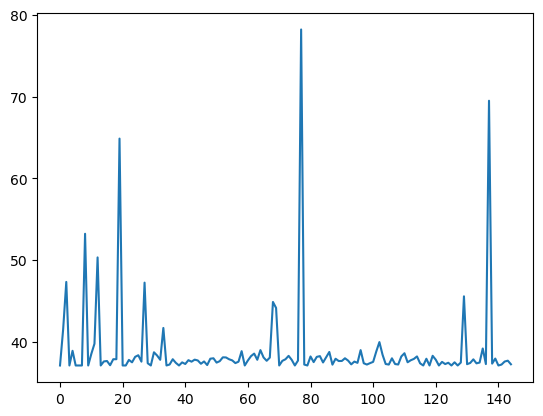

In [3]:
import copy
import matplotlib.pyplot as plt 

xs = list(range(len(ppls)))
plot_ppls = copy.deepcopy(ppls)

print("The value greater than 100: (these values will be set to ppl of noban)") 
for i in range(len(ppls)):
    if ppls[i] > 100:
        print(i, ppls[i])   
        plot_ppls[i] = ppls[0]
    elif ppls[i] == -1: # TODO 
        plot_ppls[i] = ppls[0]
    elif ppls[i] < ppls[0]:
        print(f"reduced idx {i}")

plt.plot(xs, plot_ppls)

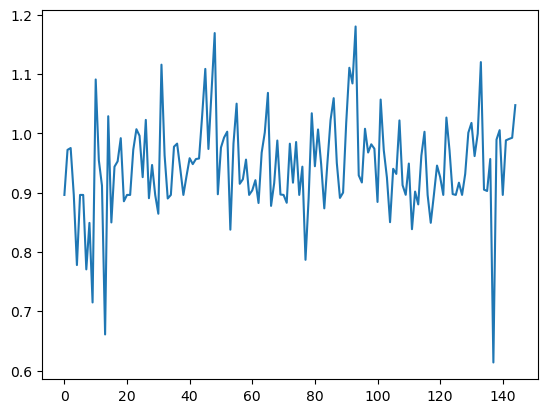

In [9]:
import copy
import matplotlib.pyplot as plt 

import matplotlib.jasfs 

xs = list(range(len(biass)))
plot_biass = copy.deepcopy(biass)
# print("The value greater than 100:") 
for i in range(len(biass)):
    if biass[i] == -1: 
        plot_biass[i] = biass[0]

plt.plot(xs, plot_biass) 

In [9]:
import numpy as np
from os import getgroups
from pathlib import Path

id = 0
folder_name = "experiment_2"
for group in ["gender_and_sex","race_ethnicity", "religion", "sexual_orientation", "nationality", "gender_and_sex"]:
  for model in ["gpt2","distilgpt2","EleutherAI/gpt-neo-125M","EleutherAI/gpt-neo-1.3B","EleutherAI/gpt-j-6B","meta-llama/Llama-2-7b-chat-hf"]:
    for pruned_heads_ratio in np.linspace(0,0.2,11,endpoint=True):
      for prompting in ["holistic"]:
        for method in ["FASP", "bias_only", "ppl_only","random_structured", "mask_gradient_l2_structured", "magnitude_l2_structured"]:
          if method == "FASP":
            gammas = ["0.2", "0.3","0.4","0.5","0.6", "0.7"]
          else:
            gammas = ["None"]
          for gamma in gammas:
              for seed in range(1,4):
                my_file = open("./scripts/sample.sh")
                string_list = my_file.readlines()

                my_file.close()

                string_list[1] = "#SBATCH --account=rrg-bengioy-ad_gpu" + "\n"
                string_list[2] = "#SBATCH --cpus-per-task=4" + "\n"
                string_list[3] = "#SBATCH --gres=gpu:1" + "\n"
                string_list[4] = "#SBATCH --mem=100G" + "\n"
                string_list[8] = "python main.py "
                string_list[5] = "#SBATCH --time=2:57:00" + "\n"

                if model == "EleutherAI/gpt-neo-125M":
                  model_name = "N1"
                elif model == "EleutherAI/gpt-neo-1.3B":
                  model_name = "N2"
                  string_list[8] += " --batch_size 32 "
                elif model == "EleutherAI/gpt-j-6B":
                  model_name = "NJ"
                  string_list[5] = "#SBATCH --time=11:57:00" + "\n"
                  string_list[8] += " --batch_size 8 "
                elif model == "meta-llama/Llama-2-7b-chat-hf":
                  model_name = "L7"
                  string_list[5] = "#SBATCH --time=11:57:00" + "\n"
                  string_list[8] += " --batch_size 8 "
                elif model == "distilgpt2":
                  model_name = "G2D"
                elif model == "gpt2":
                  model_name = "G2"

                if group == "gender_and_sex":
                  group_name = "g"
                elif group == "race_ethnicity":
                  group_name = "r"
                elif group == "religion":
                  group_name = "l"
                elif group == "sexual_orientation":
                  group_name = "s"
                elif group == "nationality":
                  group_name = "n"

                string_list[8] += " --model " + model
                string_list[8] += " --method " + str(method)
                string_list[8] += " --pruned_heads_ratio " + str(pruned_heads_ratio)
                if gamma != "None":
                  string_list[8] += " --gamma " + str(gamma)

                if prompting == "holistic":
                  prompting_abbrev="h"
                  string_list[8] += " --targeted_holistic_bias " + group

                if method == "random_structured":
                  method_name = "rn"
                elif method == "FASP":
                  method_name = "f"
                elif method == "magnitude_l2_structured":
                  method_name = "m2"
                elif method == "mask_gradient_l2_structured":
                  method_name = "mg2"
                elif method == "bias_only":
                  method_name = "bo"
                elif method == "ppl_only":
                  method_name = "po"

                string_list[8] += " --prompting " + str(prompting)
                string_list[7] = "sleep " + str(1*id) + "\n"
                file_name = "./scripts/" + folder_name  + "/" + str(prompting_abbrev) + str(seed) + "_" + str(model_name) + "_" + str(method_name) + "_"  + str(pruned_heads_ratio) + "_"  + str(group_name)

                if method == "FASP":
                  file_name += "_" + str(gamma)

                string_list[8] += " --seed " + str(seed) + " \n"
                Path("./scripts/" + folder_name).mkdir(parents=True, exist_ok=True)
                my_file = open(file_name + ".sh", "w")
                new_file_contents = "".join(string_list)
                my_file.write(new_file_contents)
                my_file.close()
              id+=1